<a href="https://colab.research.google.com/github/Tiru-Kaggundi/Trade_AI/blob/main/yearly_exports_split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install and import essentials
import pandas as pd
import numpy as np
from pathlib import Path

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = Path('/content/drive/MyDrive/ai4trade')
IN_PATH = BASE_DIR / 'data' / 'interim' / 'harmonized_trade_data.parquet'
OUT_DIR = BASE_DIR / 'data' / 'interim'

print(f"Reading from: {IN_PATH}")
print(f"Output directory: {OUT_DIR}")

Mounted at /content/drive
Reading from: /content/drive/MyDrive/ai4trade/data/interim/harmonized_trade_data.parquet
Output directory: /content/drive/MyDrive/ai4trade/data/interim


In [2]:
#@title Load harmonized parquet and inspect columns
df = pd.read_parquet(IN_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head(5))

# Quick schema check (as per project convention)
expected_cols = {'origin', 'destination', 'hs6', 'hs4', 'trade_flow', 'month', 'value'}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing expected columns: {missing}")
else:
    print("✅ Columns verified OK")

# Ensure month column is datetime
df['month'] = pd.to_datetime(df['month'], errors='coerce')
df = df.dropna(subset=['month'])

# Extract year for filtering
df['year'] = df['month'].dt.year
print(df['year'].value_counts().sort_index())

Shape: (18811510, 7)
Columns: ['origin', 'destination', 'hs6', 'hs4', 'trade_flow', 'month', 'value']


,origin,destination,hs6,hs4,trade_flow,month,value
0,CHN,ABW,030743,3074,Export,2023-06-01,29424
1,CHN,ABW,030743,3074,Export,2023-08-01,38083
2,CHN,ABW,030743,3074,Export,2023-10-01,32605
3,CHN,ABW,030743,3074,Export,2023-11-01,48420
4,CHN,ABW,070999,7099,Export,2023-10-01,179


✅ Columns verified OK
year
2023    8623596
2024    8633819
2025    1554095
Name: count, dtype: int64


In [3]:
#@title Drop flows that are zero for the entire year
# Compute yearly sums
group_cols = ['origin', 'destination', 'hs6', 'hs4', 'trade_flow', 'year']
yearly_sum = (
    df.groupby(group_cols, as_index=False)['value']
      .sum()
      .rename(columns={'value': 'yearly_total'})
)

# Merge back and filter out yearly_total==0
df = df.merge(yearly_sum, on=group_cols, how='left')
non_zero_df = df[df['yearly_total'] > 0].drop(columns=['yearly_total'])
print(f"Remaining rows after removing all-zero yearly flows: {len(non_zero_df):,}")

Remaining rows after removing all-zero yearly flows: 18,802,259


In [4]:
#@title Split into (country, flow, year) subsets and save
YEARS = [2023, 2024]
COUNTRIES = ['CHN', 'USA']
FLOWS = ['Export', 'Import']

for year in YEARS:
    for country in COUNTRIES:
        for flow in FLOWS:
            subset = non_zero_df.query("year == @year and origin == @country and trade_flow == @flow")
            if subset.empty:
                print(f"⚠️ No data for {country} {flow} {year}")
                continue

            # Keep standard columns
            subset = subset[['origin','destination','hs6','hs4','trade_flow','month','value']].copy()

            # Output path
            fname = f"{country}_{flow.lower()}s_{year}.parquet"
            out_path = OUT_DIR / fname
            subset.to_parquet(out_path, index=False)
            print(f"✅ Saved {fname}: {len(subset):,} rows")

✅ Saved CHN_exports_2023.parquet: 3,600,522 rows
✅ Saved CHN_imports_2023.parquet: 806,901 rows
✅ Saved USA_exports_2023.parquet: 2,663,488 rows
✅ Saved USA_imports_2023.parquet: 1,548,584 rows
✅ Saved CHN_exports_2024.parquet: 3,632,428 rows
✅ Saved CHN_imports_2024.parquet: 806,661 rows
✅ Saved USA_exports_2024.parquet: 2,642,466 rows
✅ Saved USA_imports_2024.parquet: 1,548,011 rows


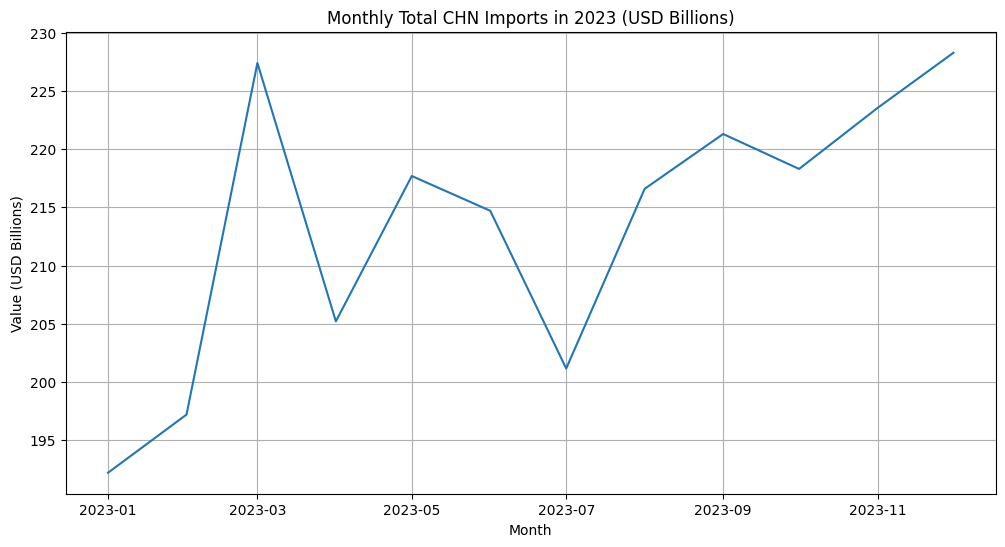

In [6]:
#@title Load CHN imports 2023 and plot monthly totals
import matplotlib.pyplot as plt
import seaborn as sns

# Load the specific parquet file
file_path = OUT_DIR / 'CHN_imports_2023.parquet'
if not file_path.exists():
    print(f"Error: File not found at {file_path}")
else:
    chn_imports_2023 = pd.read_parquet(file_path)

    # Group by month and sum the value
    monthly_imports = chn_imports_2023.groupby('month')['value'].sum().reset_index()

    # Convert to USD Billions
    monthly_imports['value_billion'] = monthly_imports['value'] / 1_000_000_000

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=monthly_imports, x='month', y='value_billion')
    plt.title('Monthly Total CHN Imports in 2023 (USD Billions)')
    plt.xlabel('Month')
    plt.ylabel('Value (USD Billions)')
    plt.grid(True)
    plt.show()

In [7]:
#@title Analyze unique destinations and top 10
if 'chn_imports_2023' in locals():
    # Get the number of unique destinations
    unique_destinations_count = chn_imports_2023['destination'].nunique()
    print(f"Number of unique destinations: {unique_destinations_count}")

    # Get the top 10 destinations by value
    top_10_destinations = chn_imports_2023.groupby('destination')['value'].sum().sort_values(ascending=False).head(10)
    print("\nTop 10 destinations by import value:")
    print(top_10_destinations)
else:
    print("Error: 'chn_imports_2023' DataFrame not found. Please run the previous cell to load the data.")

Number of unique destinations: 245

Top 10 destinations by import value:
destination
TWN    200398647719
USA    166085218224
KOR    162549206133
JPN    160822805545
AUS    154967767157
RUS    127627492025
BRA    122363447158
DEU    106506227805
CHN    105938225657
MYS    102800357203
Name: value, dtype: int64


In [8]:
# Filter the DataFrame where origin and destination are both CHN
chn_domestic_trade = chn_imports_2023.query("destination == 'CHN'").copy()

if chn_domestic_trade.empty:
    print("No data found where origin and destination are both CHN in the chn_imports_2023 dataset.")
else:
    # Group by HS6 and sum the value
    top_10_products_chn_dest = chn_domestic_trade.groupby('hs6')['value'].sum().sort_values(ascending=False).head(10)

    print("Top 10 products (HS6) where destination is CHN by import value:")
    print(top_10_products_chn_dest)

Top 10 products (HS6) where destination is CHN by import value:
hs6
854231    16413943406
854232    14274023300
854239    13738261317
854129     4368955537
847330     3965120025
847180     3509488360
851779     2318276358
854233     2243414467
851762     2167888690
847170     2144420246
Name: value, dtype: int64
